# End to End Object Detection with Transformers in ART

Notebook for applying patch attacks on DETR and calculating MAP of results

### Define imports, constants and helper functions

In [1]:
import sys 
!{sys.executable} -m pip install --user adversarial-robustness-toolbox
!{sys.executable} -m pip install --user torch
!{sys.executable} -m pip install --user pillow



from art.estimators.object_detection.pytorch_detection_transformer import PyTorchDetectionTransformer
from art.attacks.evasion.adversarial_patch.adversarial_patch_pytorch import AdversarialPatchPyTorch
from torchvision.transforms import transforms
import PIL.Image
import numpy as np
import torch
import cv2
import matplotlib.pyplot as plt
import requests
import pandas as pd

from sklearn.metrics import accuracy_score

COCO_CLASSES = [
    'N/A', 'person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus',
    'train', 'truck', 'boat', 'traffic light', 'fire hydrant', 'N/A',
    'stop sign', 'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse',
    'sheep', 'cow', 'elephant', 'bear', 'zebra', 'giraffe', 'N/A', 'backpack',
    'umbrella', 'N/A', 'N/A', 'handbag', 'tie', 'suitcase', 'frisbee', 'skis',
    'snowboard', 'sports ball', 'kite', 'baseball bat', 'baseball glove',
    'skateboard', 'surfboard', 'tennis racket', 'bottle', 'N/A', 'wine glass',
    'cup', 'fork', 'knife', 'spoon', 'bowl', 'banana', 'apple', 'sandwich',
    'orange', 'broccoli', 'carrot', 'hot dog', 'pizza', 'donut', 'cake',
    'chair', 'couch', 'potted plant', 'bed', 'N/A', 'dining table', 'N/A',
    'N/A', 'toilet', 'N/A', 'tv', 'laptop', 'mouse', 'remote', 'keyboard',
    'cell phone', 'microwave', 'oven', 'toaster', 'sink', 'refrigerator', 'N/A',
    'book', 'clock', 'vase', 'scissors', 'teddy bear', 'hair drier',
    'toothbrush'
]

def extract_predictions(predictions_, conf_thresh):
    predictions_class = [COCO_CLASSES[i] for i in list(predictions_["labels"])]
    if len(predictions_class) < 1:
        return [], [], []
        
    predictions_boxes = [[(i[0], i[1]), (i[2], i[3])] for i in list(predictions_["boxes"])]
    predictions_score = list(predictions_["scores"])

    threshold = conf_thresh
    predictions_t = [predictions_score.index(x) for x in predictions_score if x > threshold]
    if len(predictions_t) > 0:
        predictions_t = predictions_t
    else:
        return [], [], []
        
    predictions_boxes = [predictions_boxes[i] for i in predictions_t]
    predictions_class = [predictions_class[i] for i in predictions_t]
    predictions_scores = [predictions_score[i] for i in predictions_t]
    return predictions_class, predictions_boxes, predictions_scores

def plot_image_with_boxes(img, boxes, pred_cls, title):
    text_size = 2
    text_th = 2
    rect_th = 2

    for i in range(len(boxes)):
        cv2.rectangle(img, (int(boxes[i][0][0]), int(boxes[i][0][1])), (int(boxes[i][1][0]), int(boxes[i][1][1])),
                      color=(0, 255, 0), thickness=rect_th)
        cv2.putText(img, pred_cls[i], (int(boxes[i][0][0]), int(boxes[i][0][1])), cv2.FONT_HERSHEY_SIMPLEX, text_size,
                    (0, 255, 0), thickness=text_th)
    plt.figure()
    plt.axis("off")
    plt.title(title)
    plt.imshow(img)

def filter_boxes(predictions, conf_thresh):
    dictionary = {}

    boxes_list = []
    scores_list = []
    labels_list = []

    for i in range(len(predictions[0]["boxes"])):
        score = predictions[0]["scores"][i]
        if score >= conf_thresh:
            boxes_list.append(predictions[0]["boxes"][i])
            scores_list.append(predictions[0]["scores"][[i]])
            labels_list.append(predictions[0]["labels"][[i]])

    dictionary["boxes"] = np.vstack(boxes_list)
    dictionary["scores"] = np.hstack(scores_list)
    dictionary["labels"] = np.hstack(labels_list)

    y = [dictionary]

    return y

MEAN = [0.485, 0.456, 0.406]
STD = [0.229, 0.224, 0.225]
NUMBER_CHANNELS = 3
INPUT_SHAPE = (NUMBER_CHANNELS, 800, 800)

transform = transforms.Compose([
        transforms.Resize([INPUT_SHAPE[1], INPUT_SHAPE[2]], interpolation=transforms.InterpolationMode.BICUBIC),
        transforms.ToTensor()
    ])



[notice] A new release of pip available: 22.2.1 -> 23.3.1
[notice] To update, run: pip3.10 install --upgrade pip

[notice] A new release of pip available: 22.2.1 -> 23.3.1
[notice] To update, run: pip3.10 install --upgrade pip

[notice] A new release of pip available: 22.2.1 -> 23.3.1
[notice] To update, run: pip3.10 install --upgrade pip


### Load COCO images and resize

In [2]:
urls = ['http://images.cocodataset.org/val2017/000000084170.jpg']

urls_og = ['http://images.cocodataset.org/val2017/000000084170.jpg',
        'http://images.cocodataset.org/val2017/000000088462.jpg',
        'http://images.cocodataset.org/val2017/000000124798.jpg',
        'http://images.cocodataset.org/val2017/000000138979.jpg',
        'http://images.cocodataset.org/val2017/000000142585.jpg',
        'http://images.cocodataset.org/val2017/000000155341.jpg',
        'http://images.cocodataset.org/val2017/000000192607.jpg',
        'http://images.cocodataset.org/val2017/000000269942.jpg',
        'http://images.cocodataset.org/val2017/000000376625.jpg',
        'http://images.cocodataset.org/val2017/000000385190.jpg',
        'http://images.cocodataset.org/val2017/000000350002.jpg']

coco_images = []
for url in urls:
    im = PIL.Image.open(requests.get(url, stream=True).raw)
    im = transform(im).numpy()
    coco_images.append(im)
coco_images = np.array(coco_images)

### Create the detector

https://github.com/Trusted-AI/adversarial-robustness-toolbox/blob/435d4b87c42685ea9ba40dba2eebd94df2ce7ff9/art/estimators/object_detection/pytorch_detection_transformer.py#L42 Tää sanois että nää tulee samalla tavalla ulos tuotla niinkun tässä esimerkissä:
https://docs.voxel51.com/recipes/adding_detections.html
Joten implementoinnin vois tehä suoraan

In [3]:
detector = PyTorchDetectionTransformer(channels_first=True, preprocessing=(MEAN, STD), input_shape=INPUT_SHAPE, clip_values=(0,1))

Using cache found in /users/antilaan/.cache/torch/hub/facebookresearch_detr_main
/scratch/project_2008539/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/scratch/project_2008539/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


### Test detector on COCO images

In [13]:
def extract_coordinate_pair(bounding_boxes, index):
   box = bounding_boxes[index]
   x1, y1 = box[0]
   x2, y2 = box[1]
   return [x1, y1, x2, y2]

[[(160.93843, 438.88687), (284.67413, 556.0163)], [(0.036033988, 409.7125), (55.78449, 457.50256)], [(108.74818, 439.7109), (177.30432, 501.41068)], [(312.85382, 378.61966), (363.4039, 437.07294)], [(261.71207, 208.0749), (536.4725, 596.54614)]]
[160.93843, 438.88687, 284.67413, 556.0163]


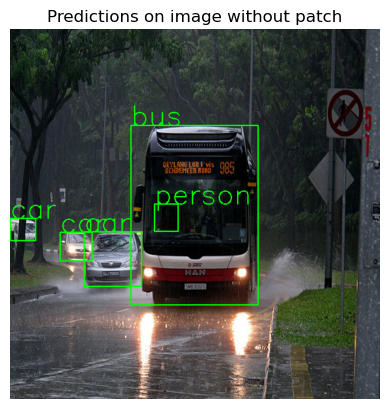

In [14]:
results = detector.predict(coco_images)
for i in range(len(results)):
    preds = extract_predictions(results[i], 0.8)
    im = (torch.from_numpy(coco_images)[i].numpy().transpose(1,2,0)*255).astype(np.uint8)
    plot_image_with_boxes(img=im.copy(), boxes=preds[1], pred_cls=preds[0], title="Predictions on image without patch")
    # otetaan yhden kuvan bbox talteen:
    print(preds[1]) #bbox
    
    #otetaan testiksi vain yksi laatikko
    pred_box = extract_coordinate_pair(preds[1], 0)
print(pred_box)

# Do evaluation for basic model

In [28]:
import json

def load_coco_annotations(file_path, image_id):
 with open(file_path, 'r') as f:
     data = json.load(f)

 annotations = data['annotations']
 bboxes_by_image_id = {}
 for annotation in annotations:
     if annotation['image_id'] == image_id:
         bbox = annotation['bbox']
         x1, y1, width, height = bbox
         x2 = x1 + width
         y2 = y1 + height
         bboxes_by_image_id[image_id] = [x1, y1, x2, y2]

 return bboxes_by_image_id

In [30]:
# Get accuracy of prediction
import re

#NYT PITÄS ANNOTAATIOSTA LADATA JUURI TÄMÄN KUVAN ANNOTAATIOT:
ann_to_load = ['http://images.cocodataset.org/val2017/000000084170.jpg']

ann_to_load_og = ['http://images.cocodataset.org/val2017/000000084170.jpg',
        'http://images.cocodataset.org/val2017/000000088462.jpg',
        'http://images.cocodataset.org/val2017/000000124798.jpg',
        'http://images.cocodataset.org/val2017/000000138979.jpg',
        'http://images.cocodataset.org/val2017/000000142585.jpg',
        'http://images.cocodataset.org/val2017/000000155341.jpg',
        'http://images.cocodataset.org/val2017/000000192607.jpg',
        'http://images.cocodataset.org/val2017/000000269942.jpg',
        'http://images.cocodataset.org/val2017/000000376625.jpg',
        'http://images.cocodataset.org/val2017/000000385190.jpg',
        'http://images.cocodataset.org/val2017/000000350002.jpg']

#kirjoita functio joka ottaa linkistä image_id:n ja tallentaa sen listaan:

def extract_image_id(s):
  numbers = [int(i) for i in re.findall(r'\d+', s)]
  return numbers[-1] if numbers else None

for url in ann_to_load:
   image_id = extract_image_id(url)
   print(image_id)

g_box = load_coco_annotations(r"/users/antilaan/annotations/instances_val2017.json", image_id)
print(g_box)
import numpy
import sklearn.metrics

# Nyt otetaan pred_box talteen
gt_box = [160.7777, 438.7777, 284.5555, 556.6666]

def intersection_over_union(gt_box, pred_box):
    inter_box_top_left = [max(gt_box[0], pred_box[0]), max(gt_box[1], pred_box[1])]
    inter_box_bottom_right = [min(gt_box[0]+gt_box[2], pred_box[0]+pred_box[2]), min(gt_box[1]+gt_box[3], pred_box[1]+pred_box[3])]

    inter_box_w = inter_box_bottom_right[0] - inter_box_top_left[0]
    inter_box_h = inter_box_bottom_right[1] - inter_box_top_left[1]

    intersection = inter_box_w * inter_box_h
    union = gt_box[2] * gt_box[3] + pred_box[2] * pred_box[3] - intersection
    
    iou = intersection / union

    return iou, intersection, union
iou, intersection, union = intersection_over_union(gt_box, pred_box)
print(iou)
print(intersection)
print(union)

84170
{84170: [254.92, 225.78, 294.56, 260.44]}
0.9972898943877458
158128.14364812925
158557.85217317072


# Show results for basic evaluation

# Adversarial patch attack

DPATCH self done https://github.com/Trusted-AI/adversarial-robustness-toolbox/blob/435d4b87c42685ea9ba40dba2eebd94df2ce7ff9/examples/get_started_fasterrcnn.py#L30

In [ ]:
from art.attacks.evasion import RobustDPatch
print("Starting robust dpatch")
dets = detector.predict(coco_images)
filtered_dets = [filter_boxes([t], 0.8)[0] for t in dets]

x = coco_images[:-1]
targets = [filtered_dets[-1] for i in range(len(x))]

brightness_range = [1.0, 1.0]
rotation_weights = [1,0,0,0]
sample_size = 1
crop_range=[0,0]
rotation_max=0.0
scale_min=0.5
scale_max=1
distortion_scale_max=0.0
learning_rate=1.0 
max_iter=100 #Tää on esimerkissä 5000
batch_size=1
patch_shape=(3, 80, 80)
patch_location=(300,300)

ap = RobustDPatch(
        detector,
        patch_shape=patch_shape,
        patch_location=patch_location,
        crop_range=crop_range,
        brightness_range=brightness_range,
        rotation_weights=rotation_weights,
        sample_size=sample_size,
        learning_rate=learning_rate,
        max_iter=max_iter,
        batch_size=batch_size,
    )

patch = ap.generate(x=x[[0]])


In [ ]:
count =0
accuracy_per_image = []
for image in coco_images:
    
    patched_images = ap.apply_patch(coco_images[[count]])
    dets = detector.predict(patched_images)
    count +=1
    if count == 5:
        break

    for i in range(len(dets)):
        preds_orig = extract_predictions(dets[i], 0.8)
        plot_image_with_boxes(img=patched_images[i].transpose(1,2,0).copy(), boxes=preds_orig[1], pred_cls=preds_orig[0],
                               title="Predictions on image with patch")
        accuracy = accuracy_score(y_true, preds_orig[2])

In [ ]:
from art.attacks.evasion import DPatch
print("Starting dpatch")
dets = detector.predict(coco_images)
filtered_dets = [filter_boxes([t], 0.8)[0] for t in dets]

x = coco_images[:-1]
targets = [filtered_dets[-1] for i in range(len(x))]

brightness_range = [1.0, 1.0]
rotation_weights = [1,0,0,0]
sample_size = 1
crop_range=[0,0]
rotation_max=0.0
scale_min=0.5
scale_max=1
distortion_scale_max=0.0
learning_rate=1.0 
max_iter=100 #Tää on esimerkissä 5000
batch_size=1
patch_shape=(3, 80, 80)
patch_location=(300,300)

ap = DPatch(
        detector,
        patch_shape=patch_shape,
        learning_rate=learning_rate,
        max_iter=max_iter,
        batch_size=batch_size,
    )

patch = ap.generate(x=x[[0]])


In [ ]:
count =0
for image in coco_images:
    
    patched_images = ap.apply_patch(coco_images[[count]])
    dets = detector.predict(patched_images)
    count +=1
    if count == 5:
        break

    for i in range(len(dets)):
        preds_orig = extract_predictions(dets[i], 0.8)
        plot_image_with_boxes(img=patched_images[i].transpose(1,2,0).copy(), boxes=preds_orig[1], pred_cls=preds_orig[0],
                               title="Predictions on image with patch")

##### Targeted attack

##### Untargeted attack

In [ ]:
dets = detector.predict(coco_images)
print("Starting untargeted path")
filtered_dets = [filter_boxes([t], 0.8)[0] for t in dets]

x = coco_images[:-1]
targets = [filtered_dets[-1] for i in range(len(x))]

rotation_max=0.0
scale_min=0.5
scale_max=1
distortion_scale_max=0.0
learning_rate=1.99
max_iter=1
batch_size=16
patch_shape=(3, 300, 300)
patch_location=(100,100)
patch_type="circle"
optimizer="adam"

ap = AdversarialPatchPyTorch(estimator=detector, rotation_max=rotation_max, 
                      scale_min=scale_min, scale_max=scale_max, distortion_scale_max=distortion_scale_max,
                      learning_rate=learning_rate, max_iter=max_iter, batch_size=batch_size, patch_location=patch_location,
                      patch_shape=patch_shape, patch_type=patch_type, verbose=True, targeted=False)

patch, patch_mask = ap.generate(x=x[[0]], y=filtered_dets[:1])

plt.axis("off")
plt.imshow(((patch) * patch_mask).transpose(1,2,0))
plt.show()

In [ ]:
# Apply patch to 10 images
count =0
for image in coco_images:
    
    patched_images = ap.apply_patch(coco_images[[count]], scale=0.3)
    dets = detector.predict(patched_images)
    count +=1
for i in range(len(dets)):
    preds_orig = extract_predictions(dets[i], 0.8)
    plot_image_with_boxes(img=patched_images[i].transpose(1,2,0).copy(), boxes=preds_orig[1], pred_cls=preds_orig[0],
                           title="Predictions on image with patch")
    print(f'Patched prediction classes for image {i+1}:', preds_orig[0])
print("untargeted patch done")

##### Untargeted attack plotting the loss components over epochs